# Get available credential

In [120]:
import json

with open("/Users/ngdnhtien/.qiskit/qiskit-ibm.json", "r") as jF:
    credential = json.load(jF)

with open("/Users/ngdnhtien/.qiskit/bank.json", "r") as bank:
    credential_bank = json.load(bank)

credential_bank = {key: value for key, value in credential_bank.items() if value['capacity'] == "full"}
token_available = next(iter(credential_bank))

credential['default-ibm-quantum']['token'] = credential_bank[token_available]['token']

with open("/Users/ngdnhtien/.qiskit/qiskit-ibm.json", "w") as jF:
    json.dump(credential, jF)

# Contents

In this notebook, I induce perform Ramsey interferometry experiment to precisely measure the transition frequency of the $(1-2)$ subspace

In [1]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/PulsatingPulseShop/')

# Necessary dependencies
import qiskit
import qiskit_ibm_provider
import utility as ut
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime

In [2]:
plt.rcParams['axes.linewidth'] = 1.1
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

In [3]:
provider = qiskit_ibm_provider.IBMProvider()
backend = provider.get_backend('ibm_brisbane')

qubit = 109
cbit = 0

num_qubits = int(qubit+1)
num_cbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')

f01 = 4.985 GHz
f12 = 4.6779 GHz


In [4]:
backend_config = backend.configuration()
dt = backend_config.dt

dt

5e-10

# Round 1

Here lies the script

In [5]:
amp_sx12 = 0.23124/2
dur_sx12 = 120

with qiskit.pulse.build(backend) as x90_pulse:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.play(qiskit.pulse.Gaussian(duration=dur_sx12,
                              amp=amp_sx12,
                              sigma=int(dur_sx12/4)), drive_chan)
    
delay_time_dt = np.arange(8, 2000, 8)

detuning_MHz = 3
ramsey_frequency = round(rough_12_freq + detuning_MHz * 1e6, 6)

delay = qiskit.circuit.Parameter('delay')

with qiskit.pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(ramsey_frequency, drive_chan)
    qiskit.pulse.call(x90_pulse)
    qiskit.pulse.delay(delay, drive_chan)
    qiskit.pulse.call(x90_pulse)

ramsey_gate = qiskit.circuit.Gate("ramsey", 1, [delay])

qc_ramsey = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
qc_ramsey.x(qubit)
qc_ramsey.append(ramsey_gate, [qubit])
qc_ramsey.x(qubit)
qc_ramsey.measure(qubit, cbit)
qc_ramsey.add_calibration(ramsey_gate, [qubit], ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: d}, inplace=False) for d in delay_time_dt]

num_shots = int(2**11)

In [6]:
ramseyv0_job = backend.run(exp_ramsey_circs, meas_level=1, meas_return='avg', shots=num_shots)
ramseyv0_job.job_id()

'cscpj3gdape00085vzj0'

In [7]:
ramseyv0_job = provider.backend.retrieve_job('cscpj3gdape00085vzj0')
ramseyv0_exp = ut.DataAnalysis(experiment=ramseyv0_job, average=True, shots=num_shots, qubit=0)
ramseyv0_exp.retrieve_data(average=True)

delay_time_sec = delay_time_dt * backend.configuration().dt

with open("./characterization/ramseyv0_12/data/round1.pkl", "wb") as f:
    pickle.dump(ramseyv0_exp.IQ_data, f)

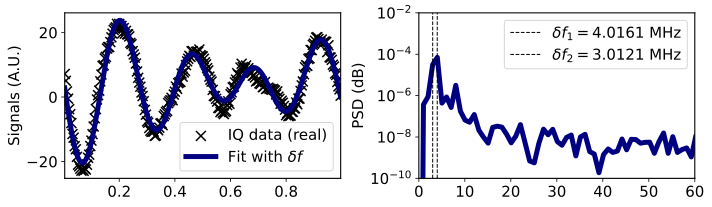

In [11]:
delay_time_sec = delay_time_dt * backend.configuration().dt
IQdata_round1 = np.load("./characterization/ramseyv0_12/data/round1.pkl", allow_pickle=True)
xdata = delay_time_sec*1e6
import scipy
backend_config = backend.configuration()
dt = backend_config.dt
fs = 1/(8*dt)
(freq, S) = scipy.signal.periodogram(IQdata_round1, fs, scaling='density')
xdata2 = freq/1e6
dominant_freq = xdata2[np.argmax(S)]
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))

ax1.scatter(xdata, IQdata_round1, marker='x', color='black', label='IQ data (real)', s=100)
ax1.set_xlim([min(xdata), max(xdata)])
popt, yfit, pcov = ut.fit_function(xdata, IQdata_round1, 
                            lambda x, A, B, T1, T2, C, phi1, phi2: (A*np.cos(2*np.pi/T1*x+phi1)+B*np.cos(2*np.pi/T2*x+phi2)+C), [30, 30, 0.4, 0.3, 0, 0, 0])
ax1.plot(xdata, yfit, color='navy', linewidth=5, label='Fit with $\delta f$')
# ax1.set_xlabel('Time domain ($\mu$s)', fontsize=15)
ax1.set_ylabel('Signals (A.U.)', fontsize=15)
ax2.semilogy(xdata2, S, color='navy', linewidth=5)
ax2.set_ylim([1e-10, 1e-2])
ax2.set_xlim([0, 60])
ax2.axvline(np.argmax(S), label=r'$\delta f_1=$'+f'{np.round(dominant_freq,4)} MHz', linestyle='--', color='black', linewidth=1)
ax2.axvline(3.0120, label=r'$\delta f_2=$'+f'{3.0121} MHz', linestyle='--', color='black', linewidth=1)
# ax2.set_xlabel('Frequency domain (MHz)', fontsize=15)
ax2.set_ylabel('PSD (dB)', fontsize=15)

for ax in [ax1, ax2]:
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.tight_layout()
fig.savefig('./characterization/ramseyv0_12/figs/ramsey12_3MHzdetuning.png', dpi=300)

## Round 2

I changed the detuning from 3 MHz to 4 MHz. Keeping the same sweeping range.

In [25]:
amp_sx12 = 0.23124/2
dur_sx12 = 120

with qiskit.pulse.build(backend) as x90_pulse:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.play(qiskit.pulse.Gaussian(duration=dur_sx12,
                              amp=amp_sx12,
                              sigma=int(dur_sx12/4)), drive_chan)
    
delay_time_dt = np.arange(8, 2000, 8)

detuning_MHz = 10
ramsey_frequency = round(rough_12_freq + detuning_MHz * 1e6, 6)

delay = qiskit.circuit.Parameter('delay')

with qiskit.pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(ramsey_frequency, drive_chan)
    qiskit.pulse.call(x90_pulse)
    qiskit.pulse.delay(delay, drive_chan)
    qiskit.pulse.call(x90_pulse)

ramsey_gate = qiskit.circuit.Gate("ramsey", 1, [delay])

qc_ramsey = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
qc_ramsey.x(qubit)
qc_ramsey.append(ramsey_gate, [qubit])
qc_ramsey.x(qubit)
qc_ramsey.measure(qubit, cbit)
qc_ramsey.add_calibration(ramsey_gate, [qubit], ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: d}, inplace=False) for d in delay_time_dt]

num_shots = int(2**11)

In [28]:
ramseyv0_job = backend.run(exp_ramsey_circs, meas_level=1, meas_return='avg', shots=num_shots)
ramseyv0_job.job_id()

'cscq374zx1qg008mb6f0'

In [30]:
ramseyv0_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [31]:
ramseyv0_job = provider.backend.retrieve_job('cscq374zx1qg008mb6f0')
ramseyv0_exp = ut.DataAnalysis(experiment=ramseyv0_job, average=True, shots=num_shots, qubit=0)
ramseyv0_exp.retrieve_data(average=True)

delay_time_sec = delay_time_dt * backend.configuration().dt

with open("./characterization/ramseyv0_12/data/round2.pkl", "wb") as f:
    pickle.dump(ramseyv0_exp.IQ_data, f)

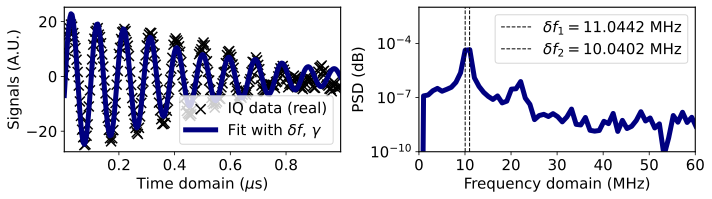

In [15]:
delay_time_sec = delay_time_dt * backend.configuration().dt
IQdata_round2 = np.load("./characterization/ramseyv0_12/data/round2.pkl", allow_pickle=True)
xdata = delay_time_sec*1e6
import scipy
backend_config = backend.configuration()
dt = backend_config.dt
fs = 1/(8*dt)
(freq, S) = scipy.signal.periodogram(IQdata_round2, fs, scaling='density')
xdata2 = freq/1e6
dominant_freq = xdata2[np.argmax(S)]
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))

ax1.scatter(xdata, IQdata_round2, marker='x', color='black', label='IQ data (real)', s=100)
ax1.set_xlim([min(xdata), max(xdata)])
popt, yfit, pcov = ut.fit_function(xdata, IQdata_round2, 
                            lambda x, A, B, T1, T2, C, phi1, phi2, gamma: (np.exp(-gamma*x)*(A*np.cos(2*np.pi/T1*x+phi1)+B*np.cos(2*np.pi/T2*x+phi2)+C)), [30, 30, 0.10, 0.11, 0, 0, 0, 0.1])
ax1.plot(xdata, yfit, color='navy', linewidth=5, label='Fit with $\delta f$, $\gamma$')
ax1.set_xlabel('Time domain ($\mu$s)', fontsize=15)
ax1.set_ylabel('Signals (A.U.)', fontsize=15)
ax2.semilogy(xdata2, S, color='navy', linewidth=5)
ax2.set_ylim([1e-10, 1e-2])
ax2.set_xlim([0, 60])
ax2.axvline(np.argmax(S), label=r'$\delta f_1=$'+f'{np.round(dominant_freq,4)} MHz', linestyle='--', color='black', linewidth=1)
ax2.axvline(xdata2[10], label=r'$\delta f_2=$'+f'{np.round(xdata2[10], 4)} MHz', linestyle='--', color='black', linewidth=1)
ax2.set_xlabel('Frequency domain (MHz)', fontsize=15)
ax2.set_ylabel('PSD (dB)', fontsize=15)

for ax in [ax1, ax2]:
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.tight_layout()
fig.savefig('./characterization/ramseyv0_12/figs/ramsey12_10MHzdetuning.png', dpi=300)

In [17]:
0.9598393574297202/2

0.4799196787148601

# Round 3

I try to better understand what's happening.

In [10]:
backend_config = backend.configuration()

dt = backend_config.dt # This is in unit of second

print(f"Sampling rate is {dt/1e-9} ns")

Sampling rate is 0.5 ns


The position of the measurement pulse is constrained to be an integral multiple of `acquire_alignment`, and the position of the gate is constrained to be an integral multiple of `pulse_alignment`.

In [11]:
backend_config.timing_constraints

{'acquire_alignment': 8,
 'granularity': 8,
 'min_length': 16,
 'pulse_alignment': 8}

In an experiment where gates and delays are repeated, such as the Ramsey experiment, it is necessary to select the `delay` so that it is the minimum common multiple of `acquire_alignment` and `pulse_alignment`.

### The Shannon-Nyquist theorem

A function containing no frequency higher than $\omega$ Hz is completely determined by sampling at $2\omega$ Hz.

In other words, by sampling at $\omega_S$, we'll be blind to signals with frequency higher than $\omega_S/2$.

In [12]:
amp_sx12 = 0.35249/2
dur_sx12 = 80

with qiskit.pulse.build(backend) as x90_pulse:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.play(qiskit.pulse.Gaussian(duration=dur_sx12,
                              amp=amp_sx12,
                              sigma=int(dur_sx12/4)), drive_chan)
    
delay_time_dt = np.arange(80, 4800, 48)

detuning_MHz = 2
ramsey_frequency = round(rough_12_freq + detuning_MHz * 1e6, 6)

delay = qiskit.circuit.Parameter('delay')

with qiskit.pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(ramsey_frequency, drive_chan)
    qiskit.pulse.call(x90_pulse)
    qiskit.pulse.delay(delay, drive_chan)
    qiskit.pulse.call(x90_pulse)

ramsey_gate = qiskit.circuit.Gate("ramsey", 1, [delay])

qc_ramsey = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
qc_ramsey.x(qubit)
qc_ramsey.append(ramsey_gate, [qubit])
qc_ramsey.x(qubit)
qc_ramsey.measure(qubit, cbit)
qc_ramsey.add_calibration(ramsey_gate, [qubit], ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: d}, inplace=False) for d in delay_time_dt]

num_shots = int(2**11)

In [123]:
ramseyv0_job = backend.run(exp_ramsey_circs, meas_level=1, meas_return='avg', shots=num_shots)
ramseyv0_job.job_id()

'cs65bwfkfpw00080r0f0'

In [13]:
ramseyv0_job = backend.provider.retrieve_job('cs65bwfkfpw00080r0f0')
ramseyv0_exp = ut.DataAnalysis(experiment=ramseyv0_job, average=True, shots=num_shots, qubit=0)
ramseyv0_exp.retrieve_data(average=True)

delay_time_sec = delay_time_dt * backend.configuration().dt

with open("./calibrator/step2_ramsey_freq/data/round3.pkl", "wb") as f:
    pickle.dump(ramseyv0_exp.IQ_data, f)

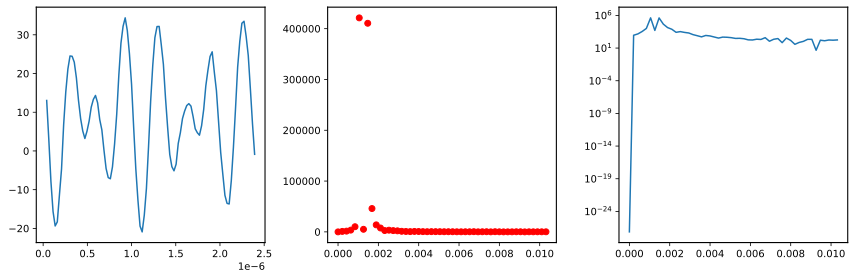

In [18]:
IQdata_round3 = np.load("./calibrator/step2_ramsey_freq/data/round3.pkl", allow_pickle=True)

import scipy

fs = 1/48
(freq, S) = scipy.signal.periodogram(IQdata_round3, fs, scaling='density')
dominant_freq = freq[np.argmax(S)]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4))

ax1.plot(delay_time_sec, IQdata_round3)
ax2.scatter(freq, S, color='red')
# ax2.set_xlim([0, 0.01])
ax3.semilogy(freq, S)
# ax2.set_ylim([1e-10, 1e-7])
fig.tight_layout()

### I construct a toy example 

In [20]:
data = np.random.rand(300) - 0.5

In [22]:
ps = np.abs(np.fft.fft(data))**2

In [23]:
ps

array([1.99745213e+01, 8.16230830e+01, 2.22745403e+01, 5.71419190e+01,
       3.67100228e+00, 1.19677678e+01, 6.55557023e+01, 3.04547061e+01,
       1.89780707e+01, 1.59919904e+01, 4.02800075e+01, 1.50661658e+01,
       1.27658141e+01, 1.49866544e+01, 3.42477315e-02, 3.07540479e+00,
       2.45302276e+01, 1.34927569e+00, 5.10982197e+00, 3.10473054e-01,
       3.65705030e+01, 1.80701493e+01, 1.22281813e+01, 8.16182546e+00,
       9.72537367e+01, 1.55102082e+01, 5.18138989e+00, 5.37234714e+00,
       2.22068806e+01, 6.37679181e+00, 2.99838660e+01, 8.53169075e+00,
       5.67855581e-01, 2.69228903e+00, 1.47323481e+01, 4.57677155e+00,
       7.27525588e+01, 4.53836996e+00, 9.18130461e+00, 2.00522359e+00,
       1.39119968e+01, 2.53862519e+01, 8.09628890e+00, 4.56072678e+00,
       6.23944302e+01, 1.80466686e+01, 2.48451097e+00, 3.15621189e+01,
       7.25022705e-02, 7.62829678e+00, 1.23782010e+01, 1.27314389e+02,
       2.39353836e-01, 6.52518065e+01, 1.43271317e+01, 4.85543465e+01,
      

# Update unavailable token

In [119]:
with open("/Users/ngdnhtien/.qiskit/bank.json", "r") as bank:
    credential_bank = json.load(bank)

credential_bank[token_available]['capacity'] = 'exhausted'

with open("/Users/ngdnhtien/.qiskit/bank.json", "w") as bank:
    json.dump(credential_bank, bank)